### How to change what is above to a RL agent? MADDPG

In [2]:
import torch
print("Is CUDA available: ", torch.cuda.is_available())
print("CUDA device count: ", torch.cuda.device_count())

Is CUDA available:  True
CUDA device count:  1


In [72]:
%reset -f
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import importlib
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt

from hyperparameter_tuning.mamg_env import MAMGEnv, softmax

In [101]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

def softmax(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / (np.sum(e_x, axis=1, keepdims=True) + 1e-16)

class MAMGEnv(gym.Env):
    def __init__(self):
        super(MAMGEnv, self).__init__()
        self.num_agents = 2
        self.env_size = 3
        self.num_goals = 2
        self.goals = np.array([[1,1.1], [0,1]]) * self.env_size #np.random.rand(self.num_goals, 2) * self.env_size
        self.state_size = self.num_agents * 2
        self.action_size = 2
        self.lambda_reg = 0.001
        self.alpha_reg = 0.001
        self.prior = np.zeros(self.num_goals) + 1.0 / self.num_goals
        self.convergence_reward = 100
        self.reward_configs = [tuple(np.repeat(i, self.num_agents)) for i in range(self.num_goals)]
        self.total_cost = 0

        self.observation_space = spaces.Box(low=0, high=self.env_size, shape=(self.state_size,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.num_agents, self.action_size), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.positions = np.array([[0,0],[1,0]])*self.env_size#np.random.rand(self.num_agents, 2) * self.env_size
        self.timesteps = 0
        self.total_cost = 0
        self.prior = np.zeros(self.num_goals) + 1.0 / self.num_goals
        return (self.positions.flatten().astype(np.float32), {})

    def step(self, action):
        actions = action.reshape((self.num_agents, 2))
        self.positions = np.clip(self.positions + actions, 0, self.env_size)
        self.timesteps += 1

        free_energy_cost, distances = self._compute_cost(self.positions, self.goals)
        movement_cost = self.lambda_reg * np.sum(actions**2)
        min_goal = np.argmin(self.prior)
        belief_goal_dist_cost = self.alpha_reg * np.sum([distances[i,min_goal] for i in range(self.num_agents)])
        total_cost = free_energy_cost + movement_cost + belief_goal_dist_cost

        self.total_cost += total_cost[0]

        terminated = bool(self.timesteps >= 10)
        truncated = False
        obs = self.positions.flatten().astype(np.float32)
        
        reward = -self.total_cost
        return obs, reward, terminated, truncated, {}
    
    def custom_cdist(self, x, goals, types = None):
        """
        Compute the pairwise distance between rows of x1 and rows of x2 based on measurement types.

        Args:
            x (np.ndarray): An array of shape (m, d)
            goals (np.ndarray): An array of shape (n, d)
            types (list): A list of measurement types for each pair of rows.
        Returns:
            np.ndarray: An array of shape (m, n) with the pairwise evidences.
        """
        # assert len(types) == x.shape[0], "Length of types must match number of rows in x"

        # Compute the pairwise differences to goals
        diff_to_goals = x[:, np.newaxis, :] - goals[np.newaxis, :, :]
        
        # Compute the pairwise distances to goals
        distances_to_goals = np.linalg.norm(diff_to_goals, axis=2)
        
        # Compute the pairwise angles to goals
        angles_to_goal = np.arctan2(diff_to_goals[:, :, 1], diff_to_goals[:, :, 0])
        
        # Compute the pairwise differences between robots
        diff_to_robot = x[:, np.newaxis, :] - x[np.newaxis, :, :]
        
        # Compute the pairwise angles between robots
        angles_to_robot = np.arctan2(diff_to_robot[:, :, 1], diff_to_robot[:, :, 0])
        
        # Compute the relative angles
        relative_angles = np.abs((angles_to_goal[np.newaxis, :, :] - angles_to_robot[:, :, np.newaxis] + np.pi) % (2 * np.pi) - np.pi)
        
        # Using cosine to value alignment, where 1 means perfectly aligned and -1 means opposite
        alignment = 1 - np.cos(relative_angles)
        # TODO: Utilize alignment for different type of bot

        return distances_to_goals

    def calculate_joint_goal_probs(self,agent_poses, goals, predict_types = None, reward_configs = None, eta = 10):
        """
        Calculate the joint goal probabilities for any number of agents and goals,
        applying a reward to specified configurations.

        Parameters:
        - agent_poses (np.ndarray): Array of shape [num_agents, 2] representing the positions of agents.
        - goals (np.ndarray): Array of shape [num_goals, 2] representing the positions of goals.
        - predict_types (list): List of types for prediction
        - reward_configs (list of tuples): List of configurations to reward. Each configuration is a tuple of goal indices.
        
        Returns:
        - joint_probabilities (np.ndarray): Array representing the joint probabilities.
        """
        num_agents = agent_poses.shape[0]
        num_goals = goals.shape[0]

        # Calculate distances between agents and goals
        distances = self.custom_cdist(agent_poses, goals)
        evidence = eta * np.exp(-1.0 / eta * distances)

        # Convert distances to probabilities using softmax
        probabilities = softmax(evidence) # Apply softmax along the goal dimension

        # Initialize joint probabilities as an array of ones with the appropriate shape
        joint_probabilities = np.ones([num_goals] * num_agents, dtype=float)

        # Calculate joint probabilities
        for i in range(num_agents):
            joint_probabilities *= probabilities[i].reshape([num_goals if j == i else 1 for j in range(num_agents)]) 

        # Only return the specified configurations
        likelihood = np.array([joint_probabilities[tuple(config)] for config in self.reward_configs], dtype=np.float64)

        # Normalize the joint probabilities
        likelihood = softmax(likelihood)

        return likelihood

    def _compute_distance(self, x, goals):
        diff = x[:, np.newaxis, :] - goals[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        return distances

    def _compute_evidence(self, x, goals, eta=10):
        distances = self._compute_distance(x, goals)
        return eta * np.exp(-1.0 / eta * distances), distances

    def _compute_entropy(self, evidence):
        sum_evidence = np.sum(evidence, axis=0)
        max_sum_evidence = np.max(sum_evidence)
        likelihood = np.exp(-(sum_evidence - max_sum_evidence)) / (np.sum(np.exp(-(sum_evidence - max_sum_evidence)) + 1e-16))
        # likelihood = np.exp(-sum_evidence) / np.sum(np.exp(-sum_evidence))
        self.posterior = softmax(likelihood * self.prior)
        total_cost = -np.dot(self.posterior, np.log(self.posterior.T)).reshape(-1).astype(np.float64)
        return total_cost

    def _compute_cost(self, x, goals):
        # evidence = self.calculate_joint_goal_probs(x, goals)
        evidence, distances = self._compute_evidence(x, goals)
        return self._compute_entropy(evidence) * 1e1, distances

    def _check_convergence(self, threshold=0.1):
        distances_to_goals = self._compute_distance(self.positions, self.goals)
        distances_to_selected_goal = [np.min(distances) for distances in distances_to_goals]
        selected_goals = [np.argmin(distances) for distances in distances_to_goals]
        all_same_goal = [selected_goals[0] == which_goal for which_goal in selected_goals]
        check = (np.array(distances_to_selected_goal) < threshold).all() and all(all_same_goal)
        return check


c:\Users\qbr5kx\Anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=500, episode_reward=-381.10 +/- 0.00
Episode length: 10.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1000, episode_reward=-381.10 +/- 0.00
Episode length: 10.00 +/- 0.00
Eval num_timesteps=1500, episode_reward=-381.10 +/- 0.00
Episode length: 10.00 +/- 0.00
Eval num_timesteps=2000, episode_reward=-381.10 +/- 0.00
Episode length: 10.00 +/- 0.00
Eval num_timesteps=2500, episode_reward=-381.33 +/- 0.00
Episode length: 10.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-381.33 +/- 0.00
Episode length: 10.00 +/- 0.00
Eval num_timesteps=3500, episode_reward=-381.33 +/- 0.00
Episode length: 10.00 +/- 0.00
Eval num_timesteps=4000, episode_reward=-381.33 +/- 0.00
Episode length: 10.00 +/- 0.00
Eval num_timesteps=4500, episode_reward=-381.44 +/- 0.00
Episode length: 10.00 +/- 0.00
Eval num_timesteps=5000, episode_reward=-381.44 +/- 0.00
Episode length: 10.00 +/- 0.00
Eval num_timesteps=5500, episode_reward=-381.44 +/- 0.00
Episode length: 10.00 +/- 0.00
Eval num_ti

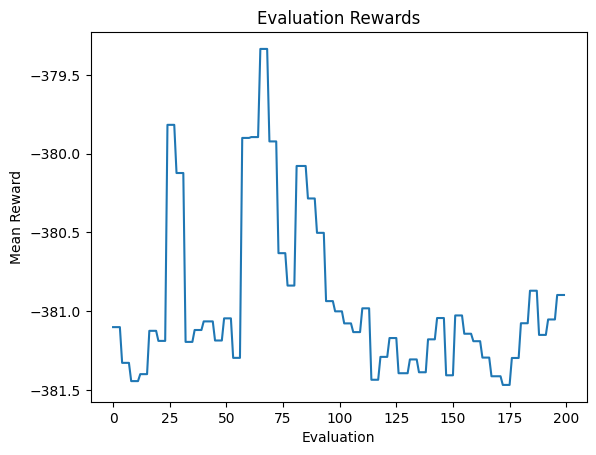

In [102]:
# Check environment
env = MAMGEnv()
check_env(env)

num_timesteps = 100000

# Setup evaluation environment
eval_env = DummyVecEnv([lambda: MAMGEnv()])

# Create EvalCallback
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)

# Train the model with EvalCallback
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=num_timesteps, callback=eval_callback)

# Save the model
model.save("ppo_multiagent")

# Load the model
model = PPO.load("ppo_multiagent")

# Load evaluation results
results = np.load('./logs/evaluations.npz')
mean_rewards = results['results'].mean(axis=1)

# Plot evaluation rewards
plt.plot(mean_rewards)
plt.xlabel('Evaluation')
plt.ylabel('Mean Reward')
plt.title('Evaluation Rewards')
plt.show()


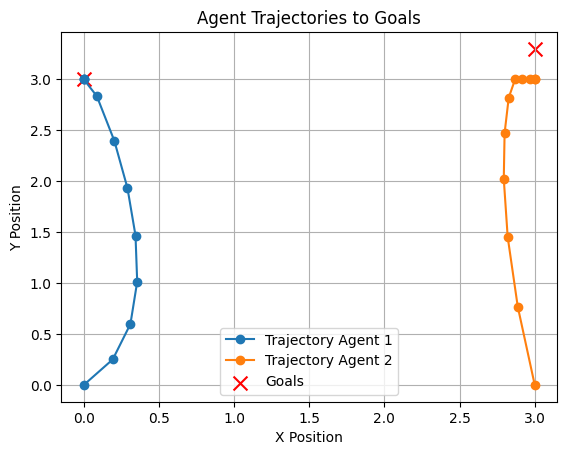

Starting position:  [[0. 0.]
 [3. 0.]]
Ending position:  [[0. 3.]
 [3. 3.]]
Done:  True
Total reward:  -381.23963207734755


In [103]:

import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt

env = MAMGEnv()
# Load the model
model = PPO.load("ppo_multiagent")

# Evaluate the trained policy
obs, info = env.reset()
trajectories = [env.get_wrapper_attr('positions').copy()]
reward_total = 0
done = False
for i in range(50):   
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    reward_total += reward
    trajectories.append(env.get_wrapper_attr('positions').copy())
    if done:
        break

trajectories = np.array(trajectories)

# Plot the resulting trajectories
for i in range(env.get_wrapper_attr('num_agents')):
    plt.plot(trajectories[:, i, 0], trajectories[:, i, 1], marker='o', label=f'Trajectory Agent {i+1}')
plt.scatter(env.get_wrapper_attr('goals')[:, 0], env.get_wrapper_attr('goals')[:, 1], marker='x', color='red', label='Goals', s=100)
plt.title('Agent Trajectories to Goals')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid()
plt.show()

print("Starting position: ", trajectories[0])
print("Ending position: ", trajectories[-1])
print("Done: ", done)
print("Total reward: ", reward_total)